# N-MNIST Advanced Benchmark: SNN vs RNN vs CNN vs Hybrid

This notebook performs a comprehensive benchmark of neuromorphic and standard deep learning models on N-MNIST.

## Models Compared
1.  **SNN (Spiking CNN)**: Fully spiking, rate-coded output.
2.  **RNN (GRU)**: Recurrent network on flattened event frames.
3.  **Hybrid (SNN-ANN)**: Spiking feature extractor -> Temporal Accumulation -> MLP.
4.  **CNN Baseline**: Standard CNN on accumulated frames (sum over time).

## Key Metrics
-   **Accuracy vs Time**: How quickly does the model reach a correct decision?
-   **Energy Proxy**: Total Spike Count (SNN) vs MACs (ANN).
-   **Latency**: Time-to-decision (earliest reliable prediction).

## 0. Configuration & Setup

In [51]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tonic
import tonic.transforms as transforms
from spikingjelly.activation_based import neuron, functional, surrogate, layer
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
import thop

# Config
SEED = 42
BATCH_SIZE = 64 
EPOCHS = 5
LR = 1e-3
T = 16          # Time steps
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

print(f"Running on {DEVICE}")

# Path Config
DATASET_ROOT = "/Users/rakeshkrai/Library/Mobile Documents/com~apple~CloudDocs/Wattr/Datasets /SNN-ANN"
MODELS_DIR = "models"
CACHE_DIR = "./cache"

if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

Running on mps


## 1. Data Loading (Optimized)
We use `tonic.DiskCachedDataset` to speed up training by caching transformed samples.

In [52]:
sensor_size = tonic.datasets.NMNIST.sensor_size

# Transform: Bin events into T frames (T, C, H, W)
snn_transform = transforms.Compose([
    transforms.ToFrame(
        sensor_size=sensor_size,
        n_time_bins=T,
    ),
    torch.tensor
])

# Load Datasets
train_ds_raw = tonic.datasets.NMNIST(save_to=DATASET_ROOT, train=True, transform=snn_transform)
test_ds_raw = tonic.datasets.NMNIST(save_to=DATASET_ROOT, train=False, transform=snn_transform)

# Cache datasets
print(f"Caching datasets to {CACHE_DIR}...")
train_ds = tonic.DiskCachedDataset(train_ds_raw, cache_path=os.path.join(CACHE_DIR, 'train'))
test_ds = tonic.DiskCachedDataset(test_ds_raw, cache_path=os.path.join(CACHE_DIR, 'test'))

# DataLoaders
num_workers = 4 # Optimized for concurrency
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=num_workers, collate_fn=tonic.collation.PadTensors(), pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=num_workers, collate_fn=tonic.collation.PadTensors(), pin_memory=True, persistent_workers=True)

print(f"Loaded {len(train_ds)} train samples and {len(test_ds)} test samples.")

Caching datasets to ./cache...
Loaded 60000 train samples and 10000 test samples.


## 2. Model Definitions
We redefine the models exactly as before to load weights successfully.

In [53]:
# --- 2.1 Spiking CNN (SNN) ---
class CSNN(nn.Module):
    def __init__(self, T: int):
        super().__init__()
        self.T = T
        self.conv = nn.Sequential(
            layer.Conv2d(2, 32, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(32),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),

            layer.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(64),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),
            
            layer.Flatten(),
            layer.Linear(64 * 8 * 8, 128, bias=False),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
            
            layer.Linear(128, 10, bias=False),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
        )
        functional.set_step_mode(self, 'm')

    def forward(self, x):
        x_seq = x.transpose(0, 1)
        functional.reset_net(self)
        return self.conv(x_seq)

# --- 2.2 RNN (GRU) ---
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 2 * 34 * 34
        hidden_size = 128
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 10)

    def forward(self, x):
        b, t, c, h, w = x.shape
        x_flat = x.view(b, t, -1)
        out, _ = self.gru(x_flat)
        return self.fc(out) # Return sequence of logits for latency analysis

# --- 2.3 Hybrid SNN-ANN ---
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            layer.Conv2d(2, 16, 3, padding=1, bias=False),
            layer.BatchNorm2d(16),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),
            
            layer.Conv2d(16, 32, 3, padding=1, bias=False),
            layer.BatchNorm2d(32),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),
        )
        functional.set_step_mode(self.feature_extractor, 'm')

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x_seq = x.transpose(0, 1)
        functional.reset_net(self.feature_extractor)
        features_seq = self.feature_extractor(x_seq)
        features_sum = features_seq.mean(dim=0)
        flat = self.flatten(features_sum)
        return self.fc2(self.relu(self.fc1(flat)))

# --- 2.4 New Baseline: CNN ---
class CNNBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # x is (B, T, C, H, W)
        # Collapse time dimension by summation
        x_accum = x.sum(dim=1)
        return self.conv(x_accum)

## 3. Load / Train Models
We load existing SNN/RNN/Hybrid checkpoints to save time. We only train the CNN Baseline.

In [54]:
def load_or_train(model, model_name, train_loader, epochs=5):
    path = os.path.join(MODELS_DIR, f"{model_name}.pth")
    
    # Try loading if exists
    if os.path.exists(path) and model_name != "cnn_baseline":
        print(f"Loading {model_name} from {path}...")
        try:
            # Load to CPU first to avoid MPS float64/device issues
            state_dict = torch.load(path, map_location='cpu')
            # strict=False ignores extra keys (like thop's total_ops)
            model.load_state_dict(state_dict, strict=False)
            model = model.to(DEVICE)
            return model
        except RuntimeError as e:
            print(f"Failed to load {model_name}: {e}. Retraining...")
    
    print(f"Training {model_name}...")
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Loss computation logic
            if 'snn' in model_name and 'hybrid' not in model_name:
                # SNN output is spikes/potentials over time. Use mean.
                loss = criterion(outputs.mean(0), labels)
            elif 'rnn' in model_name:
                # RNN output is sequence. Use last step.
                loss = criterion(outputs[:, -1, :], labels)
            else:
                # Hybrid/CNN: standard (B, C)
                loss = criterion(outputs, labels)
                
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            if 'snn' in model_name and 'hybrid' not in model_name:
                functional.reset_net(model)
            if model_name == 'hybrid_model':
                functional.reset_net(model)
                
        print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")
        
    torch.save(model.state_dict(), path)
    return model


## 4. Advanced Evaluation
### 4.1 Latency Analysis (Accuracy over Time)

In [55]:
def evaluate_latency_v2(model, loader, model_type, confidence_threshold=0.8):
    model.eval()
    correct_at_t = np.zeros(T)
    total = 0
    
    # Metrics
    time_to_decision = []
    confidence_over_time = [] # List of (T, B) arrays to be stacked later
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            batch_size = labels.size(0)
            total += batch_size
            
            # Initialize logits container (T, B, 10)
            all_logits = torch.zeros(T, batch_size, 10, device=DEVICE)

            if model_type == 'snn':
                outputs = model(inputs)
                # SNN Logic: Logits = Accumulating Spike Counts over time
                # outputs is (T, B, 10) spikes (0 or 1)
                all_logits = outputs.cumsum(dim=0)
                functional.reset_net(model)

            elif model_type == 'rnn':
                # RNN Logic: Output is sequence of logits (B, T, 10)
                outputs = model(inputs)
                all_logits = outputs.permute(1, 0, 2)

            elif model_type == 'cnn':
                # CNN Logic: Re-evaluate on accumulated frames
                for t in range(1, T + 1):
                    input_t = inputs[:, :t].sum(dim=1)
                    out_t = model(input_t)
                    all_logits[t-1] = out_t

            elif model_type == 'hybrid':
                # Hybrid Logic: Re-evaluate on partial sequence
                for t in range(1, T + 1):
                    input_t = inputs[:, :t]
                    out_t = model(input_t)
                    all_logits[t-1] = out_t
                    functional.reset_net(model)

            # Calculate accuracy at each t (using current logits)
            _, preds = all_logits.max(2)
            for t in range(T):
                correct_at_t[t] += (preds[t] == labels).sum().item()

            # Calculate Time-to-Decision & Confidence Curve
            # 1. Apply Softmax to Logits at every step
            # Note for SNN: Softmax(SpikeCount). High count = high conf.
            probs = torch.softmax(all_logits, dim=2) # (T, B, 10)
            
            # 2. Get Max Probability (Confidence) at every step
            max_conf, _ = probs.max(dim=2) # (T, B)
            
            # 3. Store batch confidence for later averaging
            confidence_over_time.append(max_conf.cpu().numpy()) 

            # 4. Find first t where conf > threshold
            met_thresh = (max_conf > confidence_threshold).int()
            has_met = met_thresh.sum(dim=0) > 0
            first_times = met_thresh.argmax(dim=0)
            
            for b in range(batch_size):
                if has_met[b]:
                    t_dec = first_times[b].item() + 1
                else:
                    t_dec = T # Penalty for never being confident
                time_to_decision.append(t_dec)

    # Aggregate Confidence Curves: (N_batches, T, B) -> (T, Total_Samples)
    # Median over samples
    all_conf = np.concatenate(confidence_over_time, axis=1) # (T, Total_Samples)
    median_conf_vs_t = np.median(all_conf, axis=1) # (T,)

    return correct_at_t / total * 100, np.median(time_to_decision), median_conf_vs_t


### 4.2 Energy Proxy (Spike Counting vs MACs)
We register hooks to count spikes in SNN layers.

In [56]:
def measure_energy(model, loader, model_type):
    global total_spikes
    total_spikes = 0
    hooks = []
    
    # Register hooks for SNN/Hybrid
    if model_type in ['snn', 'hybrid']:
        for name, module in model.named_modules():
            if isinstance(module, neuron.LIFNode):
                hooks.append(module.register_forward_hook(spike_hook))
    
    # Ensure model is on the correct device BEFORE running
    model = model.to(DEVICE)
    model.eval()
    num_samples = 0
    
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(DEVICE)
            model(inputs)
            if model_type in ['snn', 'hybrid']: 
                functional.reset_net(model)
            num_samples += inputs.size(0)
            break # Just one batch for simple estimation
            
    # Remove hooks
    for h in hooks:
        h.remove()
        
    avg_spikes = total_spikes / num_samples
    
    # Estimated MACs (using thop)
    try:
        # Use dummy input on correct device
        inputs = torch.randn(1, T, 2, 34, 34).to(DEVICE)
        if model_type == 'snn':
            # For SNN, thop gives MACs assuming dense. We scale by sparsity.
            # But real energy is ~ spikes * fan-out. 
            # We will just report Spikes.
            ops = 0
        else:
             # RNN/CNN MACs
            # Thop might reset device if not careful? Usually okay.
            # Just run it.
            ops, _ = thop.profile(model, inputs=(inputs,), verbose=False)
    except Exception as e:
        print(f"Thop profiling failed for {model_type}: {e}")
        ops = 0
        
    return avg_spikes, ops


## 5. Final Results & Plots

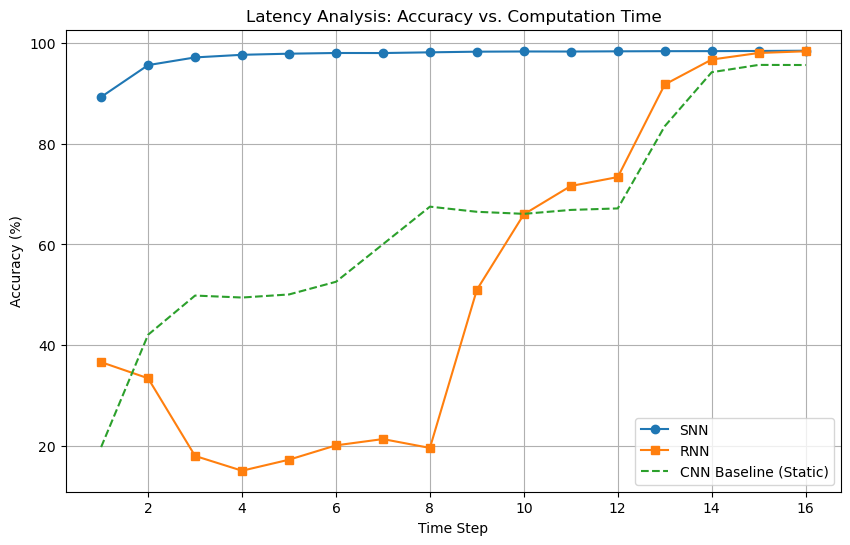

    Model  Final Accuracy  Median Time-to-Decide  Avg Spikes/Sample  \
0     SNN           98.50                   17.0       59774.203125   
1     RNN           98.39                    4.0           0.000000   
2     CNN           95.66                    7.0           0.000000   
3  Hybrid           98.71                    2.0       16241.046875   

     MACs (M)  
0    0.000000  
1  125.433856  
2    6.740224  
3    0.525568  


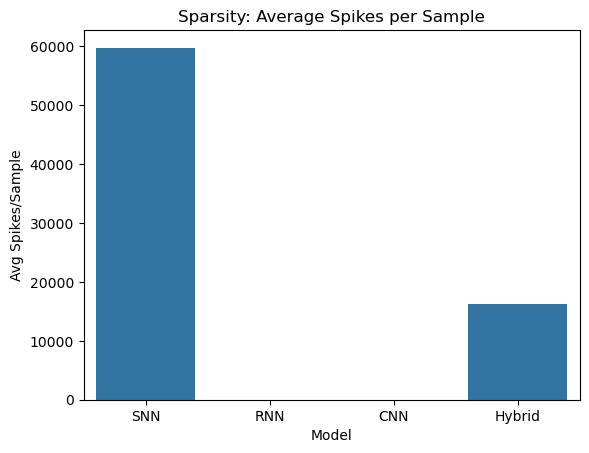

In [57]:
# 1. Accuracy vs Time Plot
plt.figure(figsize=(10, 6))
t_steps = np.arange(1, T+1)
plt.plot(t_steps, acc_snn, marker='o', label='SNN')
plt.plot(t_steps, acc_rnn, marker='s', label='RNN')
plt.plot(t_steps, acc_cnn, linestyle='--', label='CNN Baseline (Static)')
plt.xlabel("Time Step")
plt.ylabel("Accuracy (%)")
plt.title("Latency Analysis: Accuracy vs. Computation Time")
plt.legend()
plt.grid(True)
plt.show()

# 2. Summary Table
data = {
    "Model": ["SNN", "RNN", "CNN", "Hybrid"],
    "Final Accuracy": [acc_snn[-1], acc_rnn[-1], acc_cnn[-1], acc_hyb[-1]],
    "Median Time-to-Decide": [lat_snn, lat_rnn, lat_cnn, lat_hyb],
    "Avg Spikes/Sample": [energy_snn[0], energy_rnn[0], energy_cnn[0], energy_hyb[0]],
    "MACs (M)": [0, energy_rnn[1]/1e6, energy_cnn[1]/1e6, energy_hyb[1]/1e6]
}

df = pd.DataFrame(data)
print(df)

sns.barplot(x="Model", y="Avg Spikes/Sample", data=df)
plt.title("Sparsity: Average Spikes per Sample")
plt.show()